# Based on Hugging Face Transformers

https://github.com/huggingface/transformers

# Preprocessing

In [1]:
import transformers as ppb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import torch
import math

Using TensorFlow backend.


In [2]:
# For DistilBERT:
#model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-cased')

## Want BERT instead of distilBERT? Uncomment the following line:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-cased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [3]:
df = pd.read_csv("../datasets/ADR/train.tsv", sep="\t", header=None)
test_df = pd.read_csv("../datasets/ADR/test.tsv", sep="\t", header=None)

In [4]:
# Truncate long sentences to 128 tokens
X = df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128)))
y = np.array(df[1])
del df

X_test = test_df[0].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128)))
y_test = np.array(test_df[1])
del test_df

In [5]:
# One hot Encoding of y
encoder = LabelEncoder()
encoder.fit(y)

y = encoder.transform(y)
y = to_categorical(y)

# One hot Encoding of y test
y_oh = encoder.transform(y_test)
y_oh = to_categorical(y_oh)

In [6]:
def GetEmbeddings(tokenizedBatch):
    max_len = 0
    for i in tokenizedBatch.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenizedBatch.values])
    
    attention_mask = np.where(padded != 0, 1, 0)
    
    input_ids = torch.tensor(padded).to(torch.long)  
    attention_mask = torch.tensor(attention_mask)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    features = last_hidden_states[0][:,0,:].numpy()
    return features

In [7]:
BATCH_SIZE = 1000
all_embeddings = []
all_embeddings_test = []

# Process Training Set Embeddings
batches = math.ceil(X.shape[0] / BATCH_SIZE)

for i in range(1, batches+1):
    print("Generating Embeddings for Batch:",i,"of", batches)
    batchEmbeddings = GetEmbeddings(X[(i-1)*BATCH_SIZE:i*BATCH_SIZE])
    all_embeddings.append(batchEmbeddings)

# Process Test Set Embeddings
batches = math.ceil(X_test.shape[0] / BATCH_SIZE)

for i in range(1, batches+1):
    print("Generating Test Embeddings for Batch:",i,"of", batches)
    batchEmbeddings = GetEmbeddings(X_test[(i-1)*BATCH_SIZE:i*BATCH_SIZE])
    all_embeddings_test.append(batchEmbeddings)

Generating Embeddings for Batch: 1 of 6
Generating Embeddings for Batch: 2 of 6
Generating Embeddings for Batch: 3 of 6
Generating Embeddings for Batch: 4 of 6
Generating Embeddings for Batch: 5 of 6
Generating Embeddings for Batch: 6 of 6
Generating Test Embeddings for Batch: 1 of 1


In [8]:
all_embeddings = np.concatenate(all_embeddings, axis=0)
all_embeddings_test = np.concatenate(all_embeddings_test, axis=0)

In [9]:
np.save('../binary/bert_embeddings_twitter.npy', all_embeddings)
np.save('../binary/y_twitter.npy', y)
np.save('../binary/bert_embeddings_test_twitter.npy', all_embeddings_test)
np.save('../binary/y_test_twitter.npy', y_oh)

# Train Model

In [94]:
import tensorflow as tf
import tensorflow.keras as keras 
from keras.layers import Input, Lambda, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.optimizers import adam, sgd

In [95]:
all_embeddings = np.load('../binary/bert_embeddings_twitter.npy')
y = np.load('../binary/y_twitter.npy')
all_embeddings_test = np.load('../binary/bert_embeddings_test_twitter.npy')
y_oh = np.load('../binary/y_test_twitter.npy')

In [96]:
#sgd = sgd(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optim = adam(lr=0.0003, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [97]:
def build_model(): 
    embedding = Input(shape=(768,), dtype="float")
    dense1 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    dense2 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense1)
    dense3 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense2)
    dense4 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense3)
    dense5 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense4)
    dense6 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense5)
    dense7 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense6)
    dense8 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense7)
    dense9 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense8)
    dense10 = Dense(1000, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(dense9)
    pred = Dense(2, activation='sigmoid')(dense9)
    model = Model(inputs=[embedding], outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer=optim, metrics=['accuracy'], )
    return model

In [98]:
model_bert = build_model()

In [99]:
model_bert.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 768)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 1000)              769000    
_________________________________________________________________
dense_68 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_69 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_70 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_71 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_72 (Dense)             (None, 1000)              1001000   
__________

# Change to training set

In [100]:
es = EarlyStopping(monitor='loss', patience=15)
cb_list = [es]

In [101]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_bert.fit(all_embeddings, y, epochs=1000, batch_size=10000, 
                             validation_split = 0.001, callbacks=cb_list)
    model_bert.save_weights('../model/bert_logistic_twitter/model_bert_weights.h5')

Exception ignored in: <function BaseSession._Callable.__del__ at 0x00000243C60A8620>
Traceback (most recent call last):
  File "C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.
Exception ignored in: <function BaseSession._Callable.__del__ at 0x00000243C60A8620>
Traceback (most recent call last):
  File "C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Users\bisedab\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\errors_impl.py

Train on 5912 samples, validate on 6 samples
Epoch 1/1000
5912/5912 [==============================] - 3s 524us/step - loss: 9.5643 - acc: 0.5108 - val_loss: 9.4197 - val_acc: 0.8333
Epoch 2/1000
5912/5912 [==============================] - 0s 12us/step - loss: 9.4266 - acc: 0.6536 - val_loss: 9.2862 - val_acc: 0.5000
Epoch 3/1000
5912/5912 [==============================] - 0s 15us/step - loss: 9.2895 - acc: 0.6228 - val_loss: 9.1194 - val_acc: 0.6667
Epoch 4/1000
5912/5912 [==============================] - 0s 15us/step - loss: 9.1613 - acc: 0.5010 - val_loss: 9.0427 - val_acc: 0.5000
Epoch 5/1000
5912/5912 [==============================] - 0s 13us/step - loss: 9.0311 - acc: 0.5497 - val_loss: 8.8795 - val_acc: 0.6667
Epoch 6/1000
5912/5912 [==============================] - 0s 14us/step - loss: 8.8952 - acc: 0.6561 - val_loss: 8.6989 - val_acc: 0.6667
Epoch 7/1000
5912/5912 [==============================] - 0s 12us/step - loss: 8.7741 - acc: 0.5450 - val_loss: 8.6353 - val_acc: 0.

5912/5912 [==============================] - 0s 12us/step - loss: 4.5993 - acc: 0.8288 - val_loss: 4.4100 - val_acc: 0.8333
Epoch 61/1000
5912/5912 [==============================] - 0s 13us/step - loss: 4.7436 - acc: 0.6842 - val_loss: 4.4714 - val_acc: 0.8333
Epoch 62/1000
5912/5912 [==============================] - 0s 13us/step - loss: 4.4837 - acc: 0.8718 - val_loss: 4.4984 - val_acc: 0.8333
Epoch 63/1000
5912/5912 [==============================] - 0s 12us/step - loss: 4.5327 - acc: 0.7919 - val_loss: 4.4654 - val_acc: 0.8333
Epoch 64/1000
5912/5912 [==============================] - 0s 12us/step - loss: 4.5064 - acc: 0.7818 - val_loss: 4.3713 - val_acc: 0.8333
Epoch 65/1000
5912/5912 [==============================] - 0s 11us/step - loss: 4.3980 - acc: 0.8495 - val_loss: 4.2737 - val_acc: 0.8333
Epoch 66/1000
5912/5912 [==============================] - 0s 13us/step - loss: 4.3564 - acc: 0.8456 - val_loss: 4.2046 - val_acc: 0.8333
Epoch 67/1000
5912/5912 [=======================

Epoch 120/1000
5912/5912 [==============================] - 0s 11us/step - loss: 2.6868 - acc: 0.9266 - val_loss: 2.6450 - val_acc: 0.8333
Epoch 121/1000
5912/5912 [==============================] - 0s 12us/step - loss: 2.5854 - acc: 0.9767 - val_loss: 2.5075 - val_acc: 1.0000
Epoch 122/1000
5912/5912 [==============================] - 0s 13us/step - loss: 2.8050 - acc: 0.8177 - val_loss: 3.1994 - val_acc: 0.8333
Epoch 123/1000
5912/5912 [==============================] - 0s 13us/step - loss: 3.2320 - acc: 0.7026 - val_loss: 3.3781 - val_acc: 0.6667
Epoch 124/1000
5912/5912 [==============================] - 0s 11us/step - loss: 3.3083 - acc: 0.6275 - val_loss: 2.8922 - val_acc: 0.6667
Epoch 125/1000
5912/5912 [==============================] - 0s 10us/step - loss: 2.8803 - acc: 0.7380 - val_loss: 2.6846 - val_acc: 0.8333
Epoch 126/1000
5912/5912 [==============================] - 0s 13us/step - loss: 2.7396 - acc: 0.8757 - val_loss: 2.6176 - val_acc: 1.0000
Epoch 127/1000
5912/5912 [=

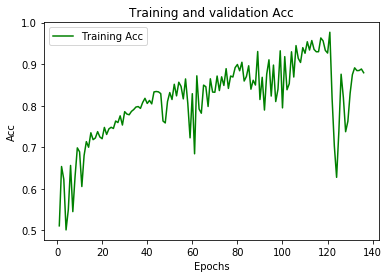

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# Predict on Test Data

In [103]:
bs = 10000
batches = math.ceil(all_embeddings_test.shape[0] / bs)

In [104]:
all_preds = []
all_probs = []
    
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    model_bert.load_weights('../model/bert_logistic_twitter/model_bert_weights.h5')

    for i in range(1,batches+1):
        print("Predicting Batch",i)
        new_text_pr = all_embeddings_test[(i-1)*bs:i*bs]
        preds = model_bert.predict(new_text_pr)
        all_probs.append(preds)
        preds = encoder.inverse_transform(np.argmax(preds,axis=1))
        all_preds.append(preds)

Predicting Batch 1


In [105]:
results = np.concatenate(all_preds, axis=0)
results_probs = np.concatenate(all_probs, axis=0)

In [106]:
np.savetxt("../output/ADR/bert_logistic_twitter/test_results.tsv", results_probs, delimiter="\t")

In [107]:
np.savetxt("../output/ADR/bert_logistic_twitter/test_predictions.tsv", results, delimiter="\t")

In [108]:
print("Accuracy: ",sum(results==y_test)/results.shape[0])

Accuracy:  0.8273381294964028
